In [1]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import Literal
from typing import TypedDict, Literal, Annotated
from langchain_core.messages import SystemMessage, HumanMessage

In [2]:
class classification_state(TypedDict):
    description: str
    class_category: str
    class_category_reason: str
    classification_prompt: str
    ground_truth: list
    current_iter: int
    max_iter: int

In [ ]:
model = ChatGoogleGenerativeAI(model='gemini-2.5-pro')

In [4]:
from pydantic import BaseModel, Field

class DescriptionEvaluation(BaseModel):
    evaluation: Literal['Pathogenic', 'Benign','Both','N/A'] = Field(..., description="ACMG Attribute class only accepted values are Pathogenic, Benign, Both,N/A")
    reason: str = Field(..., description="Reason for the classification.")

In [5]:
classification_model = model.with_structured_output(DescriptionEvaluation)

In [6]:
def description_classification(state: classification_state):
    description= state['description']
    messages = [
    SystemMessage(content=f"You are a ACMG Attribute classifier in a Healthtech organization and your duty is to classify the given description in one of the allowed classes: here are some additional details that you need to keep in my for classification {state['classification_prompt']}"),
    HumanMessage(content=f""" Here is the given description:
     {description}, 
        ########### respond only in the structure format:
        evaluation: description="ACMG Attribute class only accepted values are Pathogenic, Benign, Both,N/A
        feedback: Reason for the classification.
    """)
    ]
    response = classification_model.invoke(messages)
    print("hi")
    return {"class_category":response.evaluation,"class_category_reason":response.reason}

In [7]:
def response_check(state: classification_state):
    print("hi")
    if state['current_iter']>state['max_iter']:
        return "end"
    else:
        if state['class_category'] != state['ground_truth']:
            return "check"
        return "end"
        

In [8]:
def prompt_update(state: classification_state):
    
    description= state['description']
    messages = [
    SystemMessage(content=f"You are a ACMG Attribute classifier prompt developer for the given description, your task is to update the prompt to add the additional details which will correct your llm Prediction as your current prompt is returning {state['class_category']} but in reality it's {state['ground_truth']}, here is the reason why your LLM gave the old response {state['class_category_reason']}, now update the system prompt to get the correct response for the upcoming description"),
    HumanMessage(content=f""" Here is the given description:{description}""")
    ]
    response = model.invoke(messages).content
    print("hi")
    itter = state['current_iter']+1
    return {"classification_prompt": response,"current_iter": itter}

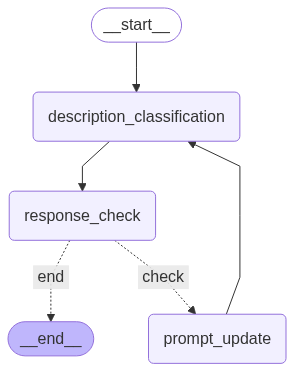

In [9]:
graph = StateGraph(classification_state)

graph.add_node('description_classification', description_classification)
graph.add_node('response_check', response_check)
graph.add_node('prompt_update', prompt_update)

graph.add_edge(START, 'description_classification')
graph.add_edge('description_classification', 'response_check')

graph.add_conditional_edges('response_check', response_check, {'end': END, 'check': 'prompt_update'})
graph.add_edge('prompt_update', 'description_classification')

workflow = graph.compile()

workflow

In [10]:
description = "The p.A2603T variant (also known as c.7807G>A), located in coding exon 16 of the BRCA2 gene, results from a G to A substitution at nucleotide position 7807. The alanine at codon 2603 is replaced by threonine, an amino acid with similar properties. This alteration was functional in a drug sensitivity assay (Ikegami M et al. Nat Commun, 2020 05;11:2573). This amino acid position is highly conserved in available vertebrate species. In addition, this alteration is predicted to be deleterious by in silico analysis. Since supporting evidence is limited at this time, the clinical significance of this alteration remains unclear."

In [11]:
initial_state = {
    "description": description,
    "current_iter": 0,
    "max_iter": 3,
    "classification_prompt":"",
    "ground_truth": "Benign"
}

In [12]:
result = workflow.invoke(initial_state)

hi
hi


InvalidUpdateError: Expected dict, got check
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE